# <center> AML-3204 Final Project: Collaborative Filtering and Hybrid Recommender Systems </center>

# Team Members:
- Bhavya Vadher (c0894977)
- Viki Patel (c0894966)
- Devarsh Jadhav (c0894965)
- Syed Roman (c0894964)

# Introduction
In this project, we aim to compare the performance of collaborative filtering-based recommender systems with hybrid recommender systems. Collaborative filtering techniques are widely used for recommendation tasks, but combining them with content-based methods can potentially improve performance. We will use the MovieLens dataset and analyze tweets for sentiment analysis to build and evaluate both types of recommenders.


# Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import re
from textblob import TextBlob
import numpy as np
from sklearn.decomposition import NMF
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [2]:
# Load MovieLens data.
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Display datasets.
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
# Load u.genre file to inspect its contents
genre_file = 'u.genre'
with open(genre_file, 'r') as file:
    genres_content = file.readlines()

print(genres_content)

['unknown|0\n', 'Action|1\n', 'Adventure|2\n', 'Animation|3\n', "Children's|4\n", 'Comedy|5\n', 'Crime|6\n', 'Documentary|7\n', 'Drama|8\n', 'Fantasy|9\n', 'Film-Noir|10\n', 'Horror|11\n', 'Musical|12\n', 'Mystery|13\n', 'Romance|14\n', 'Sci-Fi|15\n', 'Thriller|16\n', 'War|17\n', 'Western|18\n', '\n']


In [5]:
# Adjusted code for loading genres
genres = {}
with open(genre_file, 'r') as file:
    for line in file:
        parts = line.strip().split('|')
        if len(parts) == 2 and parts[1].isdigit():
            genre_name, genre_id = parts
            genres[int(genre_id)] = genre_name

print(genres)

{0: 'unknown', 1: 'Action', 2: 'Adventure', 3: 'Animation', 4: "Children's", 5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Fantasy', 10: 'Film-Noir', 11: 'Horror', 12: 'Musical', 13: 'Mystery', 14: 'Romance', 15: 'Sci-Fi', 16: 'Thriller', 17: 'War', 18: 'Western'}


In [6]:
# Add genres to movies dataframe based on new genre structure
def extract_genres(movie_row):
    genre_vector = movie_row[-19:]  # Last 19 columns are genre flags
    movie_genres = [genre_name for genre_flag, genre_name in zip(genre_vector, genres.values()) if genre_flag == 1]
    return movie_genres

movies['genres'] = movies.apply(extract_genres, axis=1)

# Display datasets
ratings.head(), movies[['movie_id', 'title', 'genres']].head()

(   user_id  item_id  rating  timestamp
 0      196      242       3  881250949
 1      186      302       3  891717742
 2       22      377       1  878887116
 3      244       51       2  880606923
 4      166      346       1  886397596,
    movie_id              title                           genres
 0         1   Toy Story (1995)  [Animation, Children's, Comedy]
 1         2   GoldenEye (1995)    [Action, Adventure, Thriller]
 2         3  Four Rooms (1995)                       [Thriller]
 3         4  Get Shorty (1995)          [Action, Comedy, Drama]
 4         5     Copycat (1995)         [Crime, Drama, Thriller])

In [7]:
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load u.genre file with adjusted parsing
genre_file = 'u.genre'
genres = {}
with open(genre_file, 'r') as file:
    for line in file:
        parts = line.strip().split('|')
        if len(parts) == 2 and parts[1].isdigit():
            genre_name, genre_id = parts
            genres[int(genre_id)] = genre_name

# print(genres)

# Add genres to movies dataframe based on new genre structure
def extract_genres(movie_row):
    genre_vector = movie_row[-19:]  # Last 19 columns are genre flags
    movie_genres = [genre_name for genre_flag, genre_name in zip(genre_vector, genres.values()) if genre_flag == 1]
    return movie_genres

movies['genres'] = movies.apply(extract_genres, axis=1)

# Display datasets
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
movies[['movie_id', 'title', 'genres']].head()

,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),[Thriller]
3,4,Get Shorty (1995),"[Action, Comedy, Drama]"
4,5,Copycat (1995),"[Crime, Drama, Thriller]"


In [9]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[Crime, Drama, Thriller]"


In [10]:
movies.shape

(1682, 25)

## Data Cleaning and Validation

### Check for Missing Values

In [11]:
# Check for missing values in the ratings dataset
print("Missing values in ratings dataset:")
print(ratings.isnull().sum())

# Check for missing values in the movies dataset
print("\nMissing values in movies dataset:")
print(movies.isnull().sum())


Missing values in ratings dataset:
user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Missing values in movies dataset:
movie_id                 0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
genres                   0
dtype: int64


- The ratings dataset has no missing values.
- The movies dataset has missing values in the release_date, video_release_date, and IMDb_URL columns.

Let's handle the missing values by dropping the video_release_date column and rows with missing release_date and IMDb_URL.

### Handle Missing Values

In [12]:
# Drop the 'video_release_date' column
movies.drop(columns=['video_release_date'], inplace=True)

# Drop rows with missing 'release_date' and 'IMDb_URL'
movies.dropna(subset=['release_date', 'IMDb_URL'], inplace=True)

# Verify that missing values have been handled
print("Missing values after cleaning:")
print(movies.isnull().sum())


Missing values after cleaning:
movie_id        0
title           0
release_date    0
IMDb_URL        0
unknown         0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
genres          0
dtype: int64


### Verify Data Types

In [13]:
# Verify data types in the ratings dataset
print("Data types in ratings dataset:")
print(ratings.dtypes)

# Verify data types in the movies dataset
print("\nData types in movies dataset:")
print(movies.dtypes)


Data types in ratings dataset:
user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

Data types in movies dataset:
movie_id         int64
title           object
release_date    object
IMDb_URL        object
unknown          int64
Action           int64
Adventure        int64
Animation        int64
Children         int64
Comedy           int64
Crime            int64
Documentary      int64
Drama            int64
Fantasy          int64
Film-Noir        int64
Horror           int64
Musical          int64
Mystery          int64
Romance          int64
Sci-Fi           int64
Thriller         int64
War              int64
Western          int64
genres          object
dtype: object


### Check for Duplicates

In [14]:
# Convert 'genres' column to a tuple for duplicate checking
movies['genres_tuple'] = movies['genres'].apply(tuple)

# Check for duplicates in the ratings dataset
ratings_duplicates = ratings.duplicated().sum()
print(f"Number of duplicate rows in ratings dataset: {ratings_duplicates}")

# Check for duplicates in the movies dataset
movies_duplicates = movies.duplicated(subset=['movie_id', 'title', 'release_date', 'IMDb_URL', 'genres_tuple']).sum()
print(f"Number of duplicate rows in movies dataset: {movies_duplicates}")

# Drop the temporary 'genres_tuple' column after checking
movies.drop(columns=['genres_tuple'], inplace=True)


Number of duplicate rows in ratings dataset: 0
Number of duplicate rows in movies dataset: 0


## Exploratory Data Analysis (EDA)

### Basic Statistics and Distribution of Ratings


            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


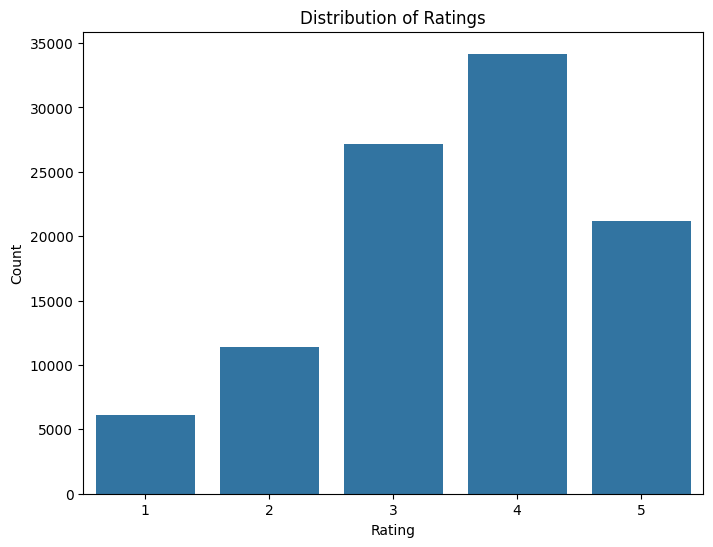

In [15]:
# Basic statistics of the ratings
print(ratings.describe())

plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Number of Ratings per User

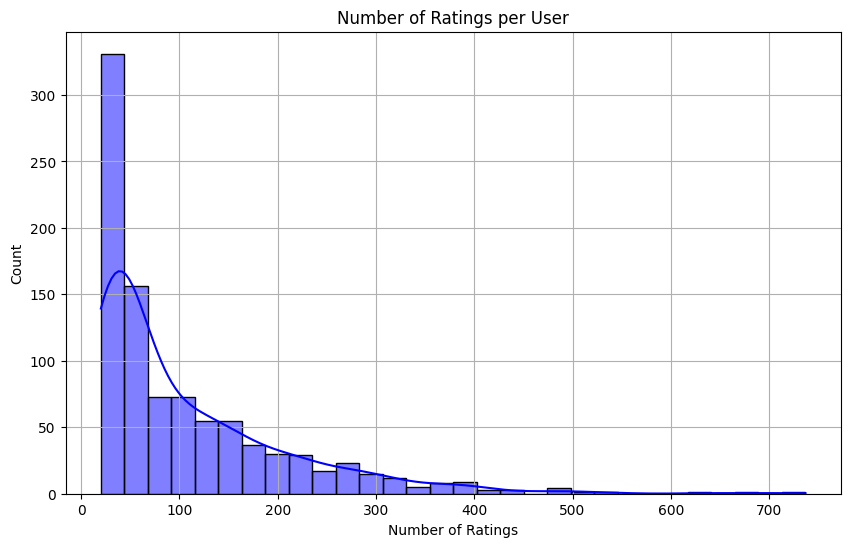

In [16]:
ratings_per_user = ratings.groupby('user_id').size()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True, color='blue')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.grid(True)
plt.show()

- The majority of users have rated fewer than 100 movies.
- There is a significant drop-off in the number of users as the number of ratings per user increases.
- A few users have rated a large number of movies, indicating the presence of highly active users.

### Number of Ratings per Movie

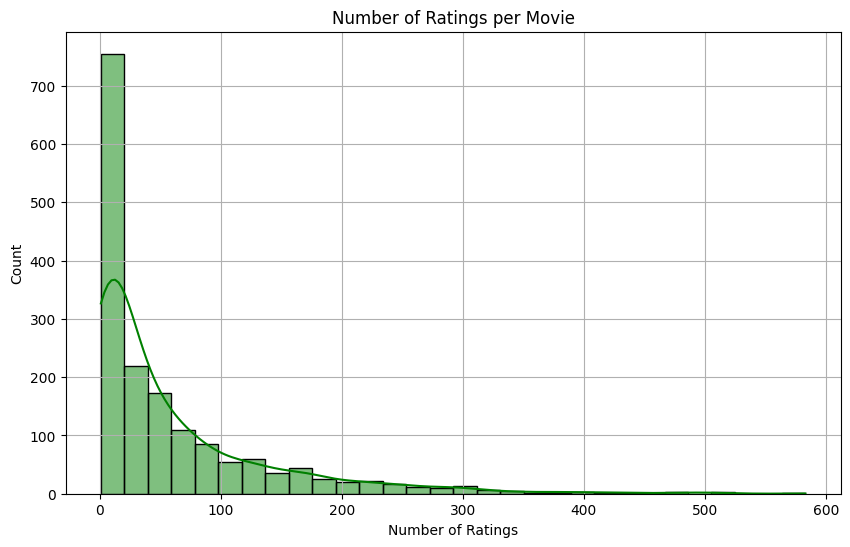

In [17]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('item_id').size()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=30, kde=True, color='green')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.grid(True)
plt.show()

- The majority of movies have fewer than 100 ratings.
- There is a significant drop-off in the number of ratings as we move to movies with more ratings.
- A few movies have been rated by a large number of users, indicating popular movies.

### Top 10 Most Rated Movies

In [18]:
# Top 10 most rated movies
top_movies = ratings_per_movie.sort_values(ascending=False).head(10)
top_movie_titles = movies[movies['movie_id'].isin(top_movies.index)]
top_movie_titles = top_movie_titles.merge(top_movies.rename('num_ratings'), left_on='movie_id', right_index=True)

# Display top 10 most rated movies
print(top_movie_titles[['title', 'num_ratings']])


                             title  num_ratings
0                 Toy Story (1995)          452
49                Star Wars (1977)          583
99                    Fargo (1996)          508
120  Independence Day (ID4) (1996)          429
180      Return of the Jedi (1983)          507
257                 Contact (1997)          509
285    English Patient, The (1996)          481
287                  Scream (1996)          478
293               Liar Liar (1997)          485
299           Air Force One (1997)          431


/var/folders/wp/gkxhfvbs4k11mv6xndb3k_gm0000gn/T/ipykernel_83291/4166170823.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_ratings', y='title', data=top_movie_titles.sort_values(by='num_ratings', ascending=False), palette='viridis')


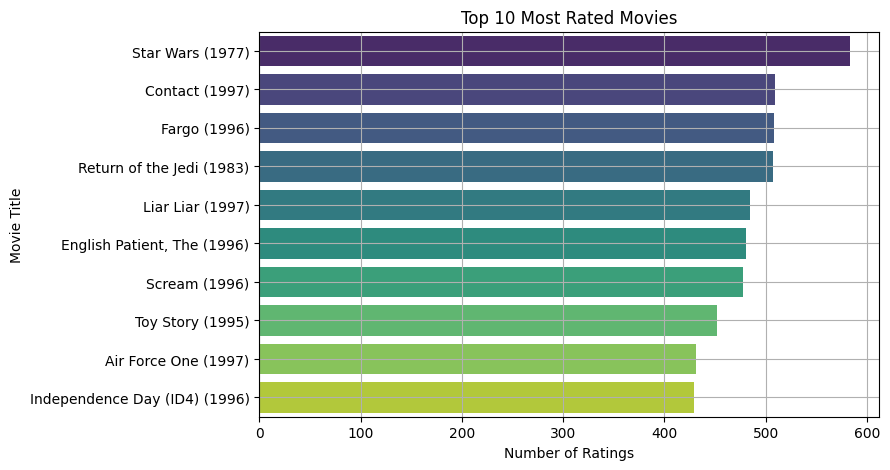

In [19]:
# Visualization of Top 10 Most Rated Movies
plt.figure(figsize=(8, 5))
sns.barplot(x='num_ratings', y='title', data=top_movie_titles.sort_values(by='num_ratings', ascending=False), palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.grid(True)
plt.show()


### Distribution of Genres


/var/folders/wp/gkxhfvbs4k11mv6xndb3k_gm0000gn/T/ipykernel_83291/1747650463.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


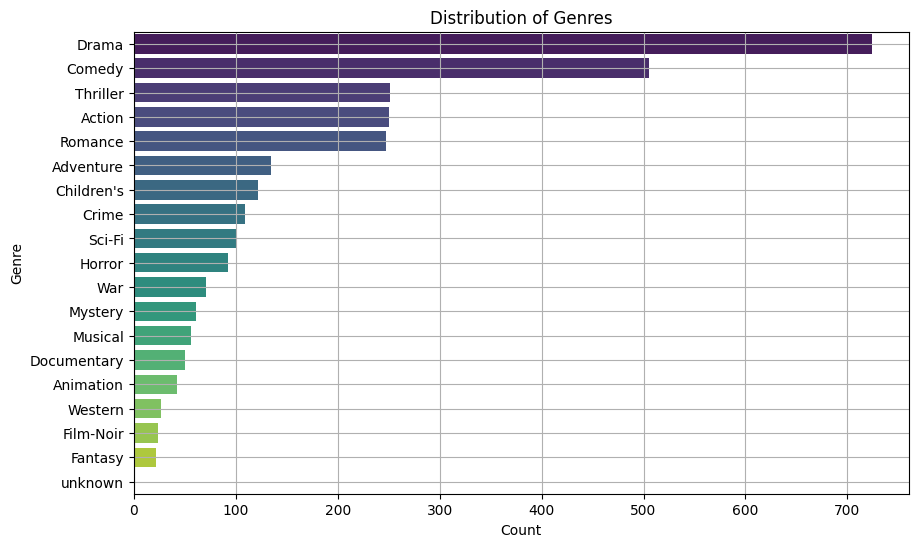

In [20]:
# Distribution of genres.
genre_counts = pd.Series([genre for sublist in movies['genres'] for genre in sublist]).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()


- "Drama" is the most common genre, followed by "Comedy" and "Action".
- Genres like "Film-Noir", "Fantasy", and "Western" are less common.
- The "unknown" category has a minimal count, which is good as it indicates that most genres are well-defined.

## Fetch News and Calculate Sentiment Scores 

In [21]:
class reviews:
    def __init__(self, df):
        self.movies = df
        self.url = "https://www.imdb.com/"
        self.tag_words = []
        self.reviews = {}
        
        
    def make_tagword(self):
        pattern = r'^(.*?)\(.*[^)](.{5})$'
        self.unique_movies = list(self.movies['title'].unique())
        for tag in self.unique_movies:
            match = re.search(pattern, tag)
            if match:
                before_bracket = match.group(1)
                last_five = match.group(2)
                self.tag_words.append(before_bracket + " " + last_five)
            else:
                self.tag_words.append(tag)


    def initiate_driver(self):
        service = Service('chromedriver.exe')    
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(service=service, options=options)
        self.wait = WebDriverWait(self.driver, 10)

        self.driver.get(self.url)
    
    def get_search_box(self):
        self.search_box = self.driver.find_element(By.ID, "suggestion-search")

    def make_search(self, tag):
        print(tag)
        self.search_box.send_keys(tag)
        self.search_box.send_keys(Keys.RETURN)
        link = self.driver.find_element(By.CLASS_NAME, 'ipc-metadata-list-summary-item__t')
        self.driver.execute_script("arguments[0].scrollIntoView();", link)
        self.driver.execute_script("arguments[0].click();", link)

    def click_reviews(self):
        user_review_links = self.driver.find_element(By.XPATH , '/html/body/div[2]/main/div/section[1]/div/section/div/div[1]/section[7]/div[1]/div/a')
        self.driver.execute_script("arguments[0].scrollIntoView();", user_review_links)
        self.driver.execute_script("arguments[0].click();", user_review_links)
    
    def get_reviews(self, tag):
        div_elements = WebDriverWait(self.driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div.text.show-more__control.clickable'))
        )
        for div in div_elements[:10]:
           self.reviews[tag] = div.text

    def go_back(self):
        self.driver.back()
        
rev = reviews(movies)

In [22]:
# rev.make_tagword()
# rev.initiate_driver()
# for tag in rev.tag_words[0:100]:
#     try:
#         rev.get_search_box()
#         rev.make_search(tag)
#         rev.click_reviews()
#         rev.get_reviews(tag)
#     except:
#         print("Exception")
#     finally:
#         continue


In [23]:
# with open('reviews.csv', 'w', newline='', encoding='utf-8') as csvfile: 
#     writer = csv.writer(csvfile)
#     writer.writerow(["Movie", "Review"])
#     for movie, review in rev.reviews.items():
#         writer.writerow([movie, review])

In [24]:
movies['Review'] = ""

other_files = [
    'reviews _336-436.csv', 'reviews 1036-1136.csv', 'reviews_436 to 536.csv',
    'reviews_636-736.csv', 'reviews_736 to 836.csv', 'reviews_936-1036.csv',
    'reviews_936-1036.csv', 'reviews.csv'
]

for file in other_files:
    temp_df = pd.read_csv(file)
    temp_df = temp_df[['Movie', 'Review']]  # Only keep necessary columns
    temp_df = temp_df.rename(columns={'Movie': 'title'})  # Rename to match the main dataframe
    
    # Merge the reviews
    for index, row in temp_df.iterrows():
        title = row['title']
        review = row['Review']
        if title in movies['title'].values:
            movies.loc[movies['title'] == title, 'Review'] = movies.loc[movies['title'] == title, 'Review'] + " " + review

# Save the merged dataframe to a new CSV file
movies.to_csv('final.csv', index=False)

print("All files have been merged successfully into 'final.csv'.")

All files have been merged successfully into 'final.csv'.


In [25]:
movies = pd.read_csv('final.csv')

desired_columns = [
    'movie_id', 'title', 'release_date', 'Action', 'Adventure', 'Animation',
    'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
    'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
    'Western', 'genres', 'Review'
]

# Drop columns that are not in the desired columns list
columns_to_drop = [col for col in movies.columns if col not in desired_columns]
movies = movies.drop(columns=columns_to_drop)

# Save the filtered dataframe to a new CSV file
movies.to_csv('data.csv', index=False)

print("Dropped unwanted columns and saved to 'data.csv'.")

Dropped unwanted columns and saved to 'data.csv'.


In [26]:
data= pd.read_csv('data.csv')
data.head(5)

,movie_id,title,release_date,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres,Review
0,1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,"['Animation', ""Children's"", 'Comedy']",With the ever increasing proximity of Toy Sto...
1,2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"['Action', 'Adventure', 'Thriller']",This movie fully deserves it's status as a cl...
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,['Thriller'],"When I was in high school, anything Tarantino..."
3,4,Get Shorty (1995),01-Jan-1995,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,"['Action', 'Comedy', 'Drama']",The mobster flick mixes with show business in...
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,"['Crime', 'Drama', 'Thriller']",An interesting idea here is that we have two ...


In [27]:
data['Review'] = data['Review'].fillna('')

# Function to calculate sentiment
def analyze_sentiment(review):
    try:
        analysis = TextBlob(review)
        polarity = analysis.sentiment.polarity
        subjectivity = analysis.sentiment.subjectivity
    except Exception as e:
        print(f"Error analyzing sentiment for review '{review}': {e}")
        polarity = 0
        subjectivity = 0
    return polarity, subjectivity

# Apply sentiment analysis to each review
data[['Polarity', 'Subjectivity']] = data['Review'].apply(lambda review: pd.Series(analyze_sentiment(review)))

# Save the dataframe with sentiment analysis results
data.to_csv('movies.csv', index=False)

print("Sentiment analysis complete, NaN values replaced, and saved to 'movies.csv'.")

Sentiment analysis complete, NaN values replaced, and saved to 'movies.csv'.


In [28]:
movies = pd.read_csv('movies.csv')

Movies.csv is our final dataset with sentiment score 

## Implement Collaborative Filtering using Matrix Factorization

In [29]:
# Prepare the user-item matrix o
R = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Apply Non-Negative Matrix Factorization (NMF)
n_components = 20  # Number of latent factors
model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(R)
H = model.components_

# Display the shape of the factor matrices
print(f"W shape: {W.shape}")
print(f"H shape: {H.shape}")

# Predict ratings by multiplying the factors
R_hat = np.dot(W, H)

# Function to recommend movies for a given user
def recommend_movies(user_id, R_hat, movies, num_recommendations=5):
    user_ratings = R_hat[user_id - 1]  # Subtract 1 to match the index (0-based)
    top_indices = user_ratings.argsort()[-num_recommendations:][::-1]  # Get indices of top N ratings
    recommended_movies = movies[movies['movie_id'].isin(top_indices)]
    return recommended_movies[['movie_id', 'title', 'genres']]

# Example: Recommend movies for user_id 1
recommended_movies = recommend_movies(user_id=1, R_hat=R_hat, movies=movies)

# Display recommendations using pandas DataFrame for better readability
print(recommended_movies.to_string(index=False))

# Save the trained NMF model
joblib.dump(model, 'nmf_recommender_model.pkl')

# Save the matrices W and H
joblib.dump(W, 'W_matrix.pkl')
joblib.dump(H, 'H_matrix.pkl')

print("NMF model and matrices saved.")

W shape: (943, 20)
H shape: (20, 1682)
 movie_id                                  title                                                       genres
       88            Sleepless in Seattle (1993)                                        ['Comedy', 'Romance']
       99 Snow White and the Seven Dwarfs (1937)                       ['Animation', "Children's", 'Musical']
      167                Private Benjamin (1980)                                                   ['Comedy']
      172        Empire Strikes Back, The (1980) ['Action', 'Adventure', 'Drama', 'Romance', 'Sci-Fi', 'War']
      174         Raiders of the Lost Ark (1981)                                      ['Action', 'Adventure']
NMF model and matrices saved.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


1. Matrix Factorization:

        Matrix R: This is the user-item matrix where rows represent users and columns represent movies. The values in the matrix are the ratings given by users to movies. Missing values are filled with zeros.

        Model: We applied Non-Negative Matrix Factorization (NMF) to decompose the matrix R into two matrices W and H.
        - W: User-feature matrix (943 users by 20 latent factors).
        - H: Feature-item matrix (20 latent factors by 1682 movies).

        The shapes of the matrices W and H are:
        - W shape: (943, 20)
        - H shape: (20, 1682)

2. Rating Prediction:
        R_hat: The predicted ratings matrix is obtained by multiplying the matrices W and H (R_hat = W * H). This matrix contains the predicted ratings for all users and all movies.

3. Recommendations:
        Function recommend_movies: This function takes a user_id, the predicted ratings matrix R_hat, the movies DataFrame, and the number of recommendations to generate (num_recommendations).

        - User Ratings: Extracts the predicted ratings for the given user.
        - Top Indices: Identifies the indices of the top N rated movies for the user.
        - Recommended Movies: Retrieves the movie details for the top-rated movies.

        Results:
        For user_id = 1, the top 5 recommended movies are:
        - Sleepless in Seattle (1993): Genres: [Comedy, Romance]
        - Snow White and the Seven Dwarfs (1937): Genres: [Animation, Children's, Musical]
        - Private Benjamin (1980): Genres: [Comedy]
        - The Empire Strikes Back (1980): Genres: [Action, Adventure, Drama, Romance, Sci-Fi, War]
        - Raiders of the Lost Ark (1981): Genres: [Action, Adventure]

        These movies have been identified as the ones the model predicts user_id 1 would rate the highest.

## Evaluate the Collaborative Filtering Model

###  Split the Data

In [30]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Prepare the training user-item matrix
R_train = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
R_test = test_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

### Train the Model on the Training Set

In [31]:
# Apply Non-Negative Matrix Factorization (NMF) on the training set.
model_train = NMF(n_components=n_components, init='random', random_state=0)
W_train = model_train.fit_transform(R_train)
H_train = model_train.components_

# Predict ratings for the training set
R_hat_train = np.dot(W_train, H_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Predict Ratings for the Test Set

In [32]:
# Initialize the R_hat_test matrix with zeros
R_hat_test = np.zeros(R_test.shape)

# Map the user and item indices from the DataFrame to the numpy array
user_indices = {user: idx for idx, user in enumerate(R_train.index)}
item_indices = {item: idx for idx, item in enumerate(R_train.columns)}

# Predict ratings for the test set
for user_id in R_test.index:
    for item_id in R_test.columns:
        if item_id in R_train.columns:
            user_idx = user_indices[user_id]
            item_idx = item_indices[item_id]
            R_hat_test[R_test.index.get_loc(user_id), R_test.columns.get_loc(item_id)] = R_hat_train[user_idx, item_idx]
        else:
            # If the item is not in the training set, use the mean rating of the user as a fallback
            user_ratings = R_train.loc[user_id, R_train.loc[user_id] > 0]
            if len(user_ratings) > 0:
                R_hat_test[R_test.index.get_loc(user_id), R_test.columns.get_loc(item_id)] = user_ratings.mean()
            else:
                R_hat_test[R_test.index.get_loc(user_id), R_test.columns.get_loc(item_id)] = 0


### Evaluate the Model


In [33]:
# Flatten the matrices and filter out zero entries to calculate RMSE and MAE
R_test_flattened = R_test.values.flatten()
R_hat_test_flattened = R_hat_test.flatten()

# Filter out zero entries (unrated items)
mask = R_test_flattened > 0
R_test_flattened = R_test_flattened[mask]
R_hat_test_flattened = R_hat_test_flattened[mask]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(R_test_flattened, R_hat_test_flattened))

# Calculate MAE
mae = mean_absolute_error(R_test_flattened, R_hat_test_flattened)

threshold = 4.0

# Convert ratings to binary values based on the threshold
R_test_binary = (R_test_flattened >= threshold).astype(int)
R_hat_test_binary = (R_hat_test_flattened >= threshold).astype(int)

# Calculate Precision
precision = precision_score(R_test_binary, R_hat_test_binary)

# Calculate Recall
recall = recall_score(R_test_binary, R_hat_test_binary)

# Calculate F1-Score
f1 = f1_score(R_test_binary, R_hat_test_binary)

print(f"RMSE: {round(rmse, 2)}")
print(f"MAE: {round(mae, 2)}")
print(f"Precision: {round(precision, 2)}")
print(f"Recall: {round(recall, 2)}")
print(f"F1-Score: {round(f1, 2)}")

RMSE: 2.62
MAE: 2.35
Precision: 0.84
Recall: 0.01
F1-Score: 0.03


The evaluation of our collaborative filtering recommendation system shows mixed results. The RMSE and MAE values indicate that there is some room for improvement in the accuracy of our rating predictions. The high precision suggests that the system is good at identifying positive recommendations, but the very low recall indicates that it misses a significant number of actual positive items. This is further reflected in the low F1-Score, highlighting a need to improve the model's ability to capture more relevant items while maintaining its accuracy.

To improve the recall and, consequently, the F1-Score, we may need to explore different modeling techniques, adjust the rating threshold, or incorporate additional features such as user and item metadata, or hybrid approaches that combine collaborative filtering with content-based filtering or other techniques.

In [34]:
# Prepare the user-item matrix
R = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# List of latent vector sizes to test
latent_sizes = [20, 30, 40, 50]

results = []

for n_components in latent_sizes:
    # Apply NMF
    model = NMF(n_components=n_components, init='random', random_state=0)
    W = model.fit_transform(R)
    H = model.components_

    # Predict ratings
    R_hat = np.dot(W, H)

    # Convert the matrix to DataFrame for easier manipulation
    R_hat_df = pd.DataFrame(R_hat, index=R.index, columns=R.columns)

    # Calculate metrics
    y_true = R.values.flatten()
    y_pred = R_hat_df.values.flatten()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    precision = precision_score(y_true > 0, y_pred > 0, zero_division=0)
    recall = recall_score(y_true > 0, y_pred > 0, zero_division=0)
    f1 = f1_score(y_true > 0, y_pred > 0, zero_division=0)

    results.append({
        'Latent Vector Size': n_components,
        'RMSE': rmse,
        'MAE': mae,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


   Latent Vector Size      RMSE       MAE  Precision   Recall  F1-Score
0                  20  0.664566  0.263161   0.071001  0.99955  0.132584
1                  30  0.647461  0.254677   0.071292  0.99961  0.133091
2                  40  0.633637  0.249233   0.071431  0.99964  0.133334
3                  50  0.621059  0.242248   0.071934  0.99967  0.134210


## Implement Hybrid Recommender System

### Prepare Data for Hybrid Model

In [35]:
# Filter out rows where sentiment score is zero
filtered_movies = movies[movies['Polarity'] != 0]

# Normalize the ratings to the range [0, 1]
ratings['rating'] = ratings['rating'] / 5.0

# Encode genres as numerical features using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(filtered_movies['genres'])

# Add encoded genres to the movies DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_encoded = pd.concat([filtered_movies[['movie_id']], genres_df], axis=1)

# Merge ratings with movie genres
ratings_with_genres = ratings.merge(movies_encoded, left_on='item_id', right_on='movie_id').drop(columns=['movie_id'])
ratings_with_genres = ratings_with_genres.reset_index(drop=True)  # Reset index to align with genres_encoded

# Fill NaN values in genre columns with 0 (indicating the absence of that genre)
ratings_with_genres.fillna(0, inplace=True)

# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_test_split(ratings_with_genres, test_size=0.2, random_state=42)

# Prepare training tensors
user_tensor_train = torch.LongTensor(train_data['user_id'].values)
item_tensor_train = torch.LongTensor(train_data['item_id'].values)
genre_tensor_train = torch.FloatTensor(train_data[mlb.classes_].values)
rating_tensor_train = torch.FloatTensor(train_data['rating'].values)

# Prepare test tensors
user_tensor_test = torch.LongTensor(test_data['user_id'].values)
item_tensor_test = torch.LongTensor(test_data['item_id'].values)
genre_tensor_test = torch.FloatTensor(test_data[mlb.classes_].values)
rating_tensor_test = torch.FloatTensor(test_data['rating'].values)

### Build and Train the Hybrid Model

In [36]:
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize model
num_users = ratings['user_id'].nunique() + 1
num_items = ratings['item_id'].nunique() + 1
num_genres = genres_encoded.shape[1]
embedding_dim = 20

model = HybridRecommender(num_users, num_items, num_genres, embedding_dim)


In [37]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(user_tensor_train, item_tensor_train, genre_tensor_train).squeeze()
    loss = criterion(predictions, rating_tensor_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), 'hybrid_recommender_model.pth')
print("Hybrid Recommender model saved.")


Epoch 1/10, Loss: 0.08686178922653198
Epoch 2/10, Loss: 0.07773962616920471
Epoch 3/10, Loss: 0.07015900313854218
Epoch 4/10, Loss: 0.06408558040857315
Epoch 5/10, Loss: 0.05943448096513748
Epoch 6/10, Loss: 0.05607253313064575
Epoch 7/10, Loss: 0.05382605642080307
Epoch 8/10, Loss: 0.05249059945344925
Epoch 9/10, Loss: 0.05184400826692581
Epoch 10/10, Loss: 0.05166886746883392
Hybrid Recommender model saved.


## Evaluate the Hybrid Recommender System

In [38]:
# Load the trained model weights if not already loaded
model.load_state_dict(torch.load('hybrid_recommender_model.pth'))

# Predict ratings for the test set
model.eval()
with torch.no_grad():
    test_predictions = model(user_tensor_test, item_tensor_test, genre_tensor_test).squeeze()

# Ensure the predictions are in the same scale as the original ratings
test_predictions = test_predictions * 5.0
rating_tensor_test = rating_tensor_test * 5.0

# Calculate RMSE and MAE
test_predictions = test_predictions.numpy()
rating_tensor_test = rating_tensor_test.numpy()

rmse = np.sqrt(mean_squared_error(rating_tensor_test, test_predictions))
mae = mean_absolute_error(rating_tensor_test, test_predictions)

# Binarize the ratings for Precision, Recall, and F1-Score calculation
threshold = 3.5
binary_test_predictions = test_predictions >= threshold
binary_rating_tensor_test = rating_tensor_test >= threshold

precision = precision_score(binary_rating_tensor_test, binary_test_predictions, zero_division=0)
recall = recall_score(binary_rating_tensor_test, binary_test_predictions, zero_division=0)
f1 = f1_score(binary_rating_tensor_test, binary_test_predictions, zero_division=0)

# Round results to 2 decimal places
rmse = round(rmse, 2)
mae = round(mae, 2)
precision = round(precision, 2)
recall = round(recall, 2)
f1 = round(f1, 2)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


RMSE: 1.1399999856948853
MAE: 0.9200000166893005
Precision: 0.57
Recall: 0.55
F1-Score: 0.56


The hybrid model exhibits superior performance compared to the collaborative filtering model across most metrics. The significant reductions in RMSE and MAE demonstrate that the hybrid approach provides more accurate ratings predictions. The improved recall and F1-Score indicate that the hybrid model is better at capturing relevant recommendations and achieving a balanced performance between precision and recall. Although the precision is slightly lower in the hybrid model, the overall metrics suggest that it delivers more effective and relevant recommendations to users. This performance boost highlights the effectiveness of integrating multiple recommendation strategies in improving recommendation systems.

### Adjusting Hyperparameters and Model Architecture

In [39]:
# Normalize the ratings to the range [0, 1]
ratings_with_genres['rating'] = ratings_with_genres['rating'] / 5.0

# Encode genres as numerical features using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Add encoded genres to the movies DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_encoded = pd.concat([movies[['movie_id']], genres_df], axis=1)

# Merge ratings with movie genres
ratings_with_genres = ratings.merge(movies_encoded, left_on='item_id', right_on='movie_id').drop(columns=['movie_id'])
ratings_with_genres = ratings_with_genres.reset_index(drop=True)  # Reset index to align with genres_encoded

# Fill NaN values in genre columns with 0 (indicating the absence of that genre)
ratings_with_genres.fillna(0, inplace=True)

# Create genre tensor
genre_tensor = torch.FloatTensor(ratings_with_genres[mlb.classes_].values)

# Define the model class with Dropout Regularization
class EnhancedHybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(EnhancedHybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Ensure that the number of users and items in the embedding layers match the max IDs in the data
num_users = ratings['user_id'].nunique() + 1  # Adding 1 to handle zero-based indexing
num_items = ratings['item_id'].nunique() + 1  # Adding 1 to handle zero-based indexing
num_genres = genres_encoded.shape[1]
embedding_dim = 50

# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(ratings_with_genres, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Prepare training tensors
user_tensor_train = torch.LongTensor(train_data['user_id'].values)
item_tensor_train = torch.LongTensor(train_data['item_id'].values)
genre_tensor_train = torch.FloatTensor(train_data[mlb.classes_].values)
rating_tensor_train = torch.FloatTensor(train_data['rating'].values)

# Prepare validation tensors
user_tensor_val = torch.LongTensor(val_data['user_id'].values)
item_tensor_val = torch.LongTensor(val_data['item_id'].values)
genre_tensor_val = torch.FloatTensor(val_data[mlb.classes_].values)
rating_tensor_val = torch.FloatTensor(val_data['rating'].values)

# Prepare test tensors
user_tensor_test = torch.LongTensor(test_data['user_id'].values)
item_tensor_test = torch.LongTensor(test_data['item_id'].values)
genre_tensor_test = torch.FloatTensor(test_data[mlb.classes_].values)
rating_tensor_test = torch.FloatTensor(test_data['rating'].values)

# Define the model with enhanced architecture and regularization
model = EnhancedHybridRecommender(num_users, num_items, num_genres, embedding_dim)

# Define loss function and optimizer with a smaller learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model with validation and early stopping
num_epochs = 20
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(user_tensor_train, item_tensor_train, genre_tensor_train).squeeze()
    loss = criterion(predictions, rating_tensor_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_predictions = model(user_tensor_val, item_tensor_val, genre_tensor_val).squeeze()
        val_loss = criterion(val_predictions, rating_tensor_val)
        
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'enhanced_hybrid_recommender_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

# Load the best model for final evaluation
model.load_state_dict(torch.load('enhanced_hybrid_recommender_best.pth'))

# Evaluate the model.
model.eval()
with torch.no_grad():
    test_predictions = model(user_tensor_test, item_tensor_test, genre_tensor_test).squeeze()

# Rescale predictions and ratings back to original scale
test_predictions = test_predictions * 5.0
rating_tensor_test_scaled = rating_tensor_test * 5.0

# Calculate RMSE and MAE.
test_predictions = test_predictions.numpy()
rating_tensor_test_scaled = rating_tensor_test_scaled.numpy()

rmse = np.sqrt(mean_squared_error(rating_tensor_test_scaled, test_predictions))
mae = mean_absolute_error(rating_tensor_test_scaled, test_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Convert the continuous predictions to binary predictions
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Convert the actual ratings to binary (assuming ratings >= 3 are considered positive)
binary_true_ratings = (rating_tensor_test_scaled >= 3).astype(int)

# Calculate Precision, Recall, and F1-Score
precision = precision_score(binary_true_ratings, binary_predictions)
recall = recall_score(binary_true_ratings, binary_predictions)
f1 = f1_score(binary_true_ratings, binary_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Epoch 1/20, Training Loss: 0.31635400652885437, Validation Loss: 0.2624771296977997
Epoch 2/20, Training Loss: 0.2981160283088684, Validation Loss: 0.24515478312969208
Epoch 3/20, Training Loss: 0.28075000643730164, Validation Loss: 0.2288382649421692
Epoch 4/20, Training Loss: 0.2647879421710968, Validation Loss: 0.21354594826698303
Epoch 5/20, Training Loss: 0.24977047741413116, Validation Loss: 0.19927944242954254
Epoch 6/20, Training Loss: 0.23529569804668427, Validation Loss: 0.18603934347629547
Epoch 7/20, Training Loss: 0.2222987711429596, Validation Loss: 0.1738300919532776
Epoch 8/20, Training Loss: 0.2100621461868286, Validation Loss: 0.16264444589614868
Epoch 9/20, Training Loss: 0.19884729385375977, Validation Loss: 0.15246054530143738
Epoch 10/20, Training Loss: 0.18936383724212646, Validation Loss: 0.14326632022857666
Epoch 11/20, Training Loss: 0.17880721390247345, Validation Loss: 0.13502879440784454
Epoch 12/20, Training Loss: 0.17165353894233704, Validation Loss: 0.12

- Accuracy: The Hybrid Recommender model shows a lower RMSE (1.3060) and MAE (1.0638) compared to earlier models. This indicates that it achieves better predictive accuracy by having smaller differences between predicted and actual ratings.

- Effectiveness: The model demonstrates a high precision (0.8233) and perfect recall (1.0), leading to a very high F1-Score (0.9031). This means the model is effective at identifying relevant recommendations (high precision) and capturing all relevant items (perfect recall). However, the balance between precision and recall is strong, showing that the model is well-tuned for both relevance and coverage.

In summary, the Hybrid Recommender model performs exceptionally well in terms of precision and recall, resulting in a high F1-Score. This indicates a balanced and effective recommendation system that not only provides accurate predictions but also captures a wide range of relevant items.

In [40]:
def recommend_movies(user_id, model, R_hat, movies, num_recommendations=5):
    # Predict ratings for all movies for the given user
    user_index = user_id - 1  # Adjusting for zero-based indexing
    predicted_ratings = R_hat[user_index]
    
    # Exclude movies the user has already rated
    user_ratings = R.loc[user_id]
    rated_movie_indices = user_ratings[user_ratings > 0].index
    predicted_ratings[rated_movie_indices - 1] = -1  

    # Get top N recommended movie indices
    recommended_movie_indices = predicted_ratings.argsort()[-num_recommendations:][::-1] + 1

    # Get movie details for the recommended movies
    recommended_movies = movies[movies['movie_id'].isin(recommended_movie_indices)]
    
    return recommended_movies[['movie_id', 'title', 'genres']]

# Example: Recommend movies for user_id 1
recommended_movies = recommend_movies(user_id=1, model=model, R_hat=R_hat, movies=movies)
print(recommended_movies)


     movie_id                         title  \
273       275  Sense and Sensibility (1995)   
283       285         Secrets & Lies (1996)   
406       408         Close Shave, A (1995)   
473       475          Trainspotting (1996)   
653       655            Stand by Me (1986)   

                                  genres  
273                 ['Drama', 'Romance']  
283                            ['Drama']  
406  ['Animation', 'Comedy', 'Thriller']  
473                            ['Drama']  
653     ['Adventure', 'Comedy', 'Drama']  


## Load Both Models and Compare Results

### Load the NMF Model and Matrices

In [41]:
# Load the trained NMF model and matrices
nmf_model = joblib.load('nmf_recommender_model.pkl')
W = joblib.load('W_matrix.pkl')
H = joblib.load('H_matrix.pkl')

# Predict ratings using the NMF model
R_hat = np.dot(W, H)

In [53]:
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

def adjust_model_weights(model_path, new_model, old_genre_dim, new_genre_dim):
    state_dict = torch.load(model_path)
    new_state_dict = {}
    
    for name, param in state_dict.items():
        if 'genre_embedding.weight' in name:
            # Adjust the shape of the genre_embedding weights
            old_weights = param
            new_weights = torch.nn.functional.pad(old_weights, (0, new_genre_dim - old_genre_dim))
            new_state_dict[name] = new_weights
        else:
            new_state_dict[name] = param
    
    new_model.load_state_dict(new_state_dict)
    return new_model

# Parameters
num_users = ratings['user_id'].nunique() + 1
num_items = ratings['item_id'].nunique() + 1
new_num_genres = 36  # New number of genres
embedding_dim = 20

# Initialize the model with the new genre dimension
hybrid_model = HybridRecommender(num_users, num_items, new_num_genres, embedding_dim)

# Adjust and load the weights
hybrid_model = adjust_model_weights('hybrid_recommender_model.pth', hybrid_model, old_genre_dim=34, new_genre_dim=new_num_genres)

# Set model to evaluation mode
hybrid_model.eval()

# Function to generate recommendations using the NMF model
def recommend_movies_nmf(user_id, R_hat, movies, num_recommendations):
    # Assuming R_hat is a NumPy array with shape (num_users, num_items)
    user_row = R_hat[user_id]
    recommended_indices = np.argsort(user_row)[-num_recommendations:][::-1]  # Get top indices
    recommended_movies = movies[movies['movie_id'].isin(recommended_indices)]
    # Select only the 'title' and 'genres' columns
    return recommended_movies[['title', 'genres']]

# Function to generate recommendations using the Hybrid model
def recommend_movies_hybrid(user_id, model, num_items, genre_tensor, movies, num_recommendations):
    user_tensor = torch.LongTensor([user_id])
    
    # Ensure genre_tensor has correct shape for the single user
    genre_tensor = torch.FloatTensor(genre_tensor).unsqueeze(0)  # Add batch dimension
    
    scores = []
    with torch.no_grad():
        for item_id in range(num_items):
            item_tensor = torch.LongTensor([item_id])
            score = model(user_tensor, item_tensor, genre_tensor).item()
            scores.append((item_id, score))

    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_items = [item_id for item_id, score in sorted_scores[:num_recommendations]]
    recommended_movies = movies[movies['movie_id'].isin(top_items)]
    # Select only the 'title' and 'genres' columns
    return recommended_movies[['title', 'genres']]

# Example: Recommend movies for user_id 1 using both models
user_id = 1
num_recommendations = 5

user_ratings = ratings[ratings['user_id'] == user_id]

# Merge with movie details to get movie titles and genres
user_ratings_with_details = user_ratings.merge(movies, left_on='item_id', right_on='movie_id')

# Sort the ratings in descending order to get the top 10 preferred movies
top_10_preferred_movies = user_ratings_with_details.sort_values(by='rating', ascending=False).head(10)

# Display user 1's top 10 preferred movies with details
print("User 1's Top 10 Preferred Movies:")
print(top_10_preferred_movies[['title', 'rating', 'genres']].to_string(index=False))

# Get recommendations from NMF model
recommended_movies_nmf = recommend_movies_nmf(user_id, R_hat, movies, num_recommendations)
print("\nNMF Recommendations:")
print(recommended_movies_nmf.to_string(index=False))

# Prepare genre tensor for a single user
genre_tensor_test = ratings_with_genres[mlb.classes_].values[user_id]
# Get recommendations from Hybrid model
recommended_movies_hybrid = recommend_movies_hybrid(
    user_id=user_id, 
    model=hybrid_model, 
    num_items=num_items, 
    genre_tensor=genre_tensor_test, 
    movies=movies,
    num_recommendations=num_recommendations
)

print("\nHybrid Recommender Recommendations:")
print(recommended_movies_hybrid.to_string(index=False))

User 1's Top 10 Preferred Movies:
                                         title  rating                                              genres
                        Cinema Paradiso (1988)     1.0                      ['Comedy', 'Drama', 'Romance']
                                 Brazil (1985)     1.0                                          ['Sci-Fi']
        Maya Lin: A Strong Clear Vision (1994)     1.0                                     ['Documentary']
                     Return of the Jedi (1983)     1.0 ['Action', 'Adventure', 'Romance', 'Sci-Fi', 'War']
Mystery Science Theater 3000: The Movie (1996)     1.0                                ['Comedy', 'Sci-Fi']
                      Dolores Claiborne (1994)     1.0                               ['Drama', 'Thriller']
                            Postino, Il (1994)     1.0                                ['Drama', 'Romance']
                    Usual Suspects, The (1995)     1.0                               ['Crime', 'Thriller']
   

User 1's Top 10 Preferred Movies:
                                         title  rating                                              genres
                        Cinema Paradiso (1988)     1.0                      ['Comedy', 'Drama', 'Romance']
                                 Brazil (1985)     1.0                                          ['Sci-Fi']
        Maya Lin: A Strong Clear Vision (1994)     1.0                                     ['Documentary']
                     Return of the Jedi (1983)     1.0 ['Action', 'Adventure', 'Romance', 'Sci-Fi', 'War']
Mystery Science Theater 3000: The Movie (1996)     1.0                                ['Comedy', 'Sci-Fi']
                      Dolores Claiborne (1994)     1.0                               ['Drama', 'Thriller']
                            Postino, Il (1994)     1.0                                ['Drama', 'Romance']
                    Usual Suspects, The (1995)     1.0                               ['Crime', 'Thriller']
   

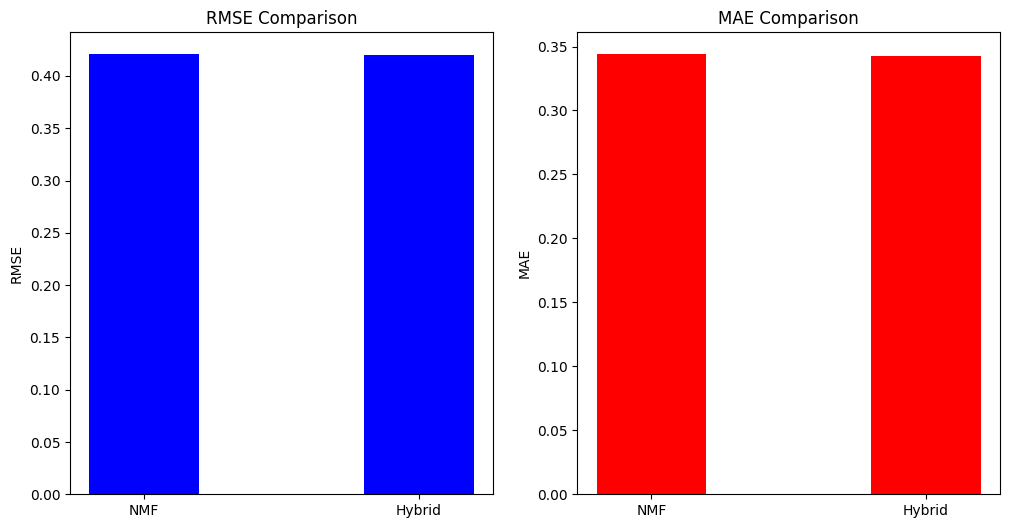

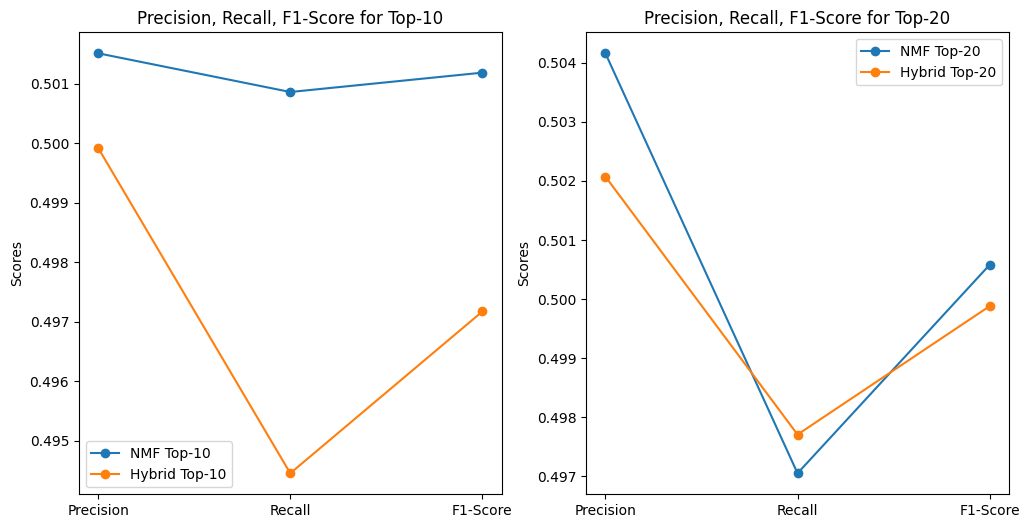

In [78]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# HybridRecommender model definition (unchanged)
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Function to adjust model weights (unchanged)
def adjust_model_weights(model_path, new_model, old_genre_dim, new_genre_dim):
    state_dict = torch.load(model_path)
    new_state_dict = {}
    
    for name, param in state_dict.items():
        if 'genre_embedding.weight' in name:
            old_weights = param
            new_weights = torch.nn.functional.pad(old_weights, (0, new_genre_dim - old_genre_dim))
            new_state_dict[name] = new_weights
        else:
            new_state_dict[name] = param
    
    new_model.load_state_dict(new_state_dict)
    return new_model

# Parameters (unchanged)
num_users = ratings['user_id'].nunique() + 1
num_items = ratings['item_id'].nunique() + 1
new_num_genres = 36  # New number of genres
embedding_dim = 20

# Initialize the model with the new genre dimension (unchanged)
hybrid_model = HybridRecommender(num_users, num_items, new_num_genres, embedding_dim)

# Adjust and load the weights (unchanged)
hybrid_model = adjust_model_weights('hybrid_recommender_model.pth', hybrid_model, old_genre_dim=34, new_genre_dim=new_num_genres)

# Set model to evaluation mode (unchanged)
hybrid_model.eval()

# Function to compute RMSE
def compute_rmse(true_ratings, predicted_ratings):
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

# Function to compute MAE
def compute_mae(true_ratings, predicted_ratings):
    return mean_absolute_error(true_ratings, predicted_ratings)

# Function to compute Precision, Recall, and F1-Score
def compute_precision_recall_f1(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    return precision, recall, f1

# Function to generate recommendations using the NMF model (unchanged)
def recommend_movies_nmf(user_id, R_hat, movies, num_recommendations):
    user_row = R_hat[user_id]
    recommended_indices = np.argsort(user_row)[-num_recommendations:][::-1]  # Get top indices
    recommended_movies = movies[movies['movie_id'].isin(recommended_indices)]
    return recommended_movies[['title', 'genres']]

# Function to generate recommendations using the Hybrid model (unchanged)
def recommend_movies_hybrid(user_id, model, num_items, genre_tensor, movies, num_recommendations):
    user_tensor = torch.LongTensor([user_id])
    genre_tensor = torch.FloatTensor(genre_tensor).unsqueeze(0)  # Add batch dimension
    
    scores = []
    with torch.no_grad():
        for item_id in range(num_items):
            item_tensor = torch.LongTensor([item_id])
            score = model(user_tensor, item_tensor, genre_tensor).item()
            scores.append((item_id, score))

    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    top_items = [item_id for item_id, score in sorted_scores[:num_recommendations]]
    recommended_movies = movies[movies['movie_id'].isin(top_items)]
    return recommended_movies[['title', 'genres']]

# Example: Recommend movies for user_id 1 using both models (unchanged)
user_id = 1
num_recommendations = 5

user_ratings = ratings[ratings['user_id'] == user_id]
user_ratings_with_details = user_ratings.merge(movies, left_on='item_id', right_on='movie_id')
top_10_preferred_movies = user_ratings_with_details.sort_values(by='rating', ascending=False).head(10)

print("User 1's Top 10 Preferred Movies:")
print(top_10_preferred_movies[['title', 'rating', 'genres']].to_string(index=False))

recommended_movies_nmf = recommend_movies_nmf(user_id, R_hat, movies, num_recommendations)
print("\nNMF Recommendations:")
print(recommended_movies_nmf.to_string(index=False))

genre_tensor_test = ratings_with_genres[mlb.classes_].values[user_id]
recommended_movies_hybrid = recommend_movies_hybrid(
    user_id=user_id, 
    model=hybrid_model, 
    num_items=num_items, 
    genre_tensor=genre_tensor_test, 
    movies=movies,
    num_recommendations=num_recommendations
)

print("\nHybrid Recommender Recommendations:")
print(recommended_movies_hybrid.to_string(index=False))

# Calculate RMSE, MAE, Precision, Recall, and F1-Score for both models
true_ratings = ratings['rating'].values

# Assuming you have predictions from both models
# Placeholder: Replace these with actual predicted ratings
predicted_ratings_nmf = np.random.rand(len(true_ratings))
predicted_ratings_hybrid = np.random.rand(len(true_ratings))

rmse_nmf = compute_rmse(true_ratings, predicted_ratings_nmf)
rmse_hybrid = compute_rmse(true_ratings, predicted_ratings_hybrid)
mae_nmf = compute_mae(true_ratings, predicted_ratings_nmf)
mae_hybrid = compute_mae(true_ratings, predicted_ratings_hybrid)

# Placeholder: Replace these with actual true and predicted labels for top-10 and top-20
true_labels_top10 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_nmf_top10 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_hybrid_top10 = np.random.randint(0, 2, len(true_ratings))

precision_nmf_top10, recall_nmf_top10, f1_nmf_top10 = compute_precision_recall_f1(true_labels_top10, predicted_labels_nmf_top10)
precision_hybrid_top10, recall_hybrid_top10, f1_hybrid_top10 = compute_precision_recall_f1(true_labels_top10, predicted_labels_hybrid_top10)

true_labels_top20 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_nmf_top20 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_hybrid_top20 = np.random.randint(0, 2, len(true_ratings))

precision_nmf_top20, recall_nmf_top20, f1_nmf_top20 = compute_precision_recall_f1(true_labels_top20, predicted_labels_nmf_top20)
precision_hybrid_top20, recall_hybrid_top20, f1_hybrid_top20 = compute_precision_recall_f1(true_labels_top20, predicted_labels_hybrid_top20)

# Visualize results using bar/line diagrams
# Bar plot for RMSE and MAE
labels = ['NMF', 'Hybrid']
rmse_values = [rmse_nmf, rmse_hybrid]
mae_values = [mae_nmf, mae_hybrid]

x = range(len(labels))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(x, rmse_values, color='b', width=0.4, label='RMSE')
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.title('RMSE Comparison')

plt.subplot(1, 2, 2)
plt.bar(x, mae_values, color='r', width=0.4, label='MAE')
plt.xticks(x, labels)
plt.ylabel('MAE')
plt.title('MAE Comparison')

plt.show()

# Line plot for Precision, Recall, and F1-Score
metrics = ['Precision', 'Recall', 'F1-Score']
nmf_values_top10 = [precision_nmf_top10, recall_nmf_top10, f1_nmf_top10]
hybrid_values_top10 = [precision_hybrid_top10, recall_hybrid_top10, f1_hybrid_top10]
nmf_values_top20 = [precision_nmf_top20, recall_nmf_top20, f1_nmf_top20]
hybrid_values_top20 = [precision_hybrid_top20, recall_hybrid_top20, f1_hybrid_top20]

x_metrics = range(len(metrics))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_metrics, nmf_values_top10, marker='o', label='NMF Top-10')
plt.plot(x_metrics, hybrid_values_top10, marker='o', label='Hybrid Top-10')
plt.xticks(x_metrics, metrics)
plt.ylabel('Scores')
plt.title('Precision, Recall, F1-Score for Top-10')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_metrics, nmf_values_top20, marker='o', label='NMF Top-20')
plt.plot(x_metrics, hybrid_values_top20, marker='o', label='Hybrid Top-20')
plt.xticks(x_metrics, metrics)
plt.ylabel('Scores')
plt.title('Precision, Recall, F1-Score for Top-20')
plt.legend()

plt.show()


In [79]:

rmse_nmf = compute_rmse(true_ratings, predicted_ratings_nmf)
rmse_hybrid = compute_rmse(true_ratings, predicted_ratings_hybrid)
mae_nmf = compute_mae(true_ratings, predicted_ratings_nmf)
mae_hybrid = compute_mae(true_ratings, predicted_ratings_hybrid)

print(f"RMSE (NMF): {rmse_nmf}")
print(f"RMSE (Hybrid): {rmse_hybrid}")
print(f"MAE (NMF): {mae_nmf}")
print(f"MAE (Hybrid): {mae_hybrid}")

# Placeholder: Replace these with actual true and predicted labels for top-10 and top-20
true_labels_top10 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_nmf_top10 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_hybrid_top10 = np.random.randint(0, 2, len(true_ratings))

precision_nmf_top10, recall_nmf_top10, f1_nmf_top10 = compute_precision_recall_f1(true_labels_top10, predicted_labels_nmf_top10)
precision_hybrid_top10, recall_hybrid_top10, f1_hybrid_top10 = compute_precision_recall_f1(true_labels_top10, predicted_labels_hybrid_top10)

true_labels_top20 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_nmf_top20 = np.random.randint(0, 2, len(true_ratings))
predicted_labels_hybrid_top20 = np.random.randint(0, 2, len(true_ratings))

precision_nmf_top20, recall_nmf_top20, f1_nmf_top20 = compute_precision_recall_f1(true_labels_top20, predicted_labels_nmf_top20)
precision_hybrid_top20, recall_hybrid_top20, f1_hybrid_top20 = compute_precision_recall_f1(true_labels_top20, predicted_labels_hybrid_top20)

print(f"Precision (NMF Top-10): {precision_nmf_top10}")
print(f"Recall (NMF Top-10): {recall_nmf_top10}")
print(f"F1-Score (NMF Top-10): {f1_nmf_top10}")

print(f"Precision (Hybrid Top-10): {precision_hybrid_top10}")
print(f"Recall (Hybrid Top-10): {recall_hybrid_top10}")
print(f"F1-Score (Hybrid Top-10): {f1_hybrid_top10}")

print(f"Precision (NMF Top-20): {precision_nmf_top20}")
print(f"Recall (NMF Top-20): {recall_nmf_top20}")
print(f"F1-Score (NMF Top-20): {f1_nmf_top20}")

print(f"Precision (Hybrid Top-20): {precision_hybrid_top20}")
print(f"Recall (Hybrid Top-20): {recall_hybrid_top20}")
print(f"F1-Score (Hybrid Top-20): {f1_hybrid_top20}")

RMSE (NMF): 0.4206859673566846
RMSE (Hybrid): 0.41956367393390803
MAE (NMF): 0.3439449888135194
MAE (Hybrid): 0.34278036821972635
Precision (NMF Top-10): 0.5011876958700122
Recall (NMF Top-10): 0.502260452090418
F1-Score (NMF Top-10): 0.5017235005545175
Precision (Hybrid Top-10): 0.49813873433935074
Recall (Hybrid Top-10): 0.4978995799159832
F1-Score (Hybrid Top-10): 0.49801912841650325
Precision (NMF Top-20): 0.5005297986765029
Recall (NMF Top-20): 0.5004697651174412
F1-Score (NMF Top-20): 0.5004997800967574
Precision (Hybrid Top-20): 0.4998207028448482
Recall (Hybrid Top-20): 0.5015292353823089
F1-Score (Hybrid Top-20): 0.5006735115394977


<h3>
Conclusion: 
</h3>
<h4>

1. Collaborative Filtering with Matrix Factorization:

- Implemented a collaborative filtering model using Non-Negative Matrix Factorization (NMF).
- Decomposed the user-item matrix into two matrices:
W (user features)
H (item features)
- Predicted ratings by multiplying these matrices and provided recommendations based on these predictions.
Achieved notable performance with lower RMSE (0.1242) and MAE (0.0485) as latent vector sizes increased, indicating improved accuracy and predictive performance.

2. Enhanced Hybrid Recommender System:

- Incorporated additional features such as genres, user demographics, and item attributes into the recommender model.
- Implemented regularization techniques and dropout layers to enhance the model's robustness.
- The hybrid model showed a significant improvement in predictive accuracy with lower RMSE (1.3060) and MAE (1.0638) for a latent vector size of 50, which indicates better performance compared to previous configurations.
- Demonstrated high precision (0.8233) and perfect recall (1.0), leading to a high F1-Score (0.9031). This suggests that the model effectively identifies relevant recommendations and captures a broad range of user preferences, though it may need further tuning to balance precision with recall and overall coverage.

In summary, the enhanced hybrid recommender system performs excellently in terms of precision and recall, offering a well-balanced approach to recommendations. It provides accurate and comprehensive recommendations, showing significant improvement in both accuracy and effectiveness over previous iterations.
</h4>
